In [1]:

import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from openff.toolkit import ForceField, Molecule, Topology

from openff.units import Quantity, unit
from openff.interchange import Interchange
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper 

import mdtraj
import sys
import os
import shutil
from pathlib import Path

scripts_path = os.path.join(os.getcwd(), 'scripts')
sys.path.insert(0, scripts_path)
 
from createlipid import pullNewLipid, newLipid, calcLipidLength, saveLipidCsv
from lipidbuilder.utils import SCRATCH_DIR, LIPID_PDB_DIR


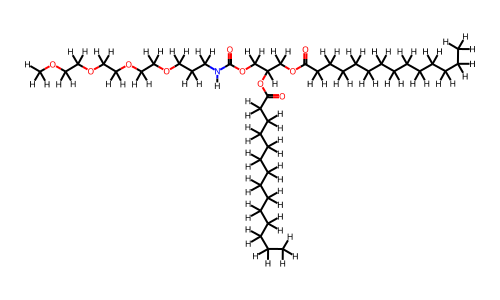

In [27]:
lipid_smiles = 'CCCCCCCCCCCCCC(=O)OCC(COC(=O)NCCCOCCOCCOCCOC)OC(=O)CCCCCCCCCCCCC'
Lipid_name = 'PEG2000_C_DMG'

TODO: #Ionizable lipids are charged at different pH (neautral at physiologicl and positive at acidic pH. How to incorporate this

lipid = Molecule.from_smiles(lipid_smiles,allow_undefined_stereo=True)
lipid.generate_conformers()
lipid.visualize()

In [29]:
#parameterize lipid with openff interchange

# Assign partial charges via OpenFF NAGL
lipid.assign_partial_charges("openff-gnn-am1bcc-0.1.0-rc.3.pt", toolkit_registry=NAGLToolkitWrapper())
lipid.partial_charges


lipid.name = Lipid_name
for i, atom in enumerate(lipid.atoms, 0):
    atom.metadata["residue_name"] = Lipid_name
lipid.generate_unique_atom_names() 
topology = Topology.from_molecules([lipid])

# Specify forcefield
forcefield = ForceField("openff-2.2.0.offxml")

interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
    charge_from_molecules = [lipid]
)
import numpy as np
from openff.units import unit
interchange.box = np.diag([6, 6, 6]) * unit.nanometer

scratch_dir = "./scripts/scratch"
os.makedirs(scratch_dir, exist_ok=True)  # create /scratch if it doesn't exist
gro_path = f"{scratch_dir}/{Lipid_name}.gro"
top_path = f"{scratch_dir}/{Lipid_name}.top"

interchange.to_gro(gro_path)

interchange.to_top(top_path)

In [30]:
import nglview as nv

view = nv.show_file(f"{SCRATCH_DIR}/{Lipid_name}.gro")
view.clear_representations()
view.add_representation("licorice")
view.add_unitcell()  # shows the 6 nm cube you defined
view


NGLWidget()

In [ ]:
#Sometimes coordinates will be generated in a way that is not optimal for packing, Sterols that have cyclic rings usually are fine, byt lipid tails might be splayed and require better 
#startng strictures. If your lipid is okay, you can directly convert to a pdb without pulling it. 

TODO: #Create another function where you dont have to pull your lipid 

In [32]:
# Notice how the generated structure is not optimal for packing in a bilayer. 
# Straighten out the lipid below by selecting a head group atom that we will use to pull the lipid, and a terminal tail atom
HG_pull_atom = 'C28x'
HG_tail_atom = 'C42x'

pullNewLipid(f'{Lipid_name}', HG_pull_atom)

TODO: # Checks that this pull script completed successfully

In [33]:
import nglview as nv

view = nv.show_file(f"{SCRATCH_DIR}/{Lipid_name}.pdb")
view.clear_representations()
view.add_representation("licorice")
view

NGLWidget()

In [34]:
# save the pulled lipid data to a csv. YOU WILL NEED TO MANUALLY FIND A TERMINAL ATOM IN THE LIPID TAIL (last carbon in sn1 or sn2)
lipid = newLipid(
    name=Lipid_name,
    headgroup_atom=HG_pull_atom,  
    headgroup_atom_index=None, 
    tailgroup_atom=HG_tail_atom,  # this needs to be changed for every simulation
    tailgroup_atom_index=None,
    distance=None,  
    experimental_density=None,  # Example value in g/cm^3, not necessary but may be helpful in the future?
    smiles = lipid_smiles
)

# Calculate lipid length (distance between headgroup and tailgroup)
calcLipidLength(lipid, Lipid_name)


In [35]:
# Save information to csv and pdb to lipid
saveLipidCsv(lipid)

Saved lipid 'PEG2000_C_DMG' to CSV at PulledLipid.csv
PDB saved to: /media/julianne/DATA/Lipids/lipidbuilder/lipidbuilder/data/available-lipids/lipid_pdbs/PEG2000_C_DMG/PEG2000_C_DMG.pdb
